In [1]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from ase import *
from ase.io import read
from gpaw import *

from gpaw.utilities.dos import LCAODOS, RestartLCAODOS


from gpaw.lcao.pwf2 import LCAOwrap
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms, lowdin_rotation
from ase.io import read
from qtpyt.basis import Basis

import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import itertools

### Helper functions

In [2]:
cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

In [3]:
def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)

def create_active_hamiltonian(H, S,  index_active_region):
    # Create a list of indices to retain
    indices_to_keep = sorted(list(index_active_region))

    # Create the H_active matrix by extracting the relevant rows and columns
    H_active = H[np.ix_(indices_to_keep, indices_to_keep)]
    S_active = S[np.ix_(indices_to_keep, indices_to_keep)]

    return H_active, S_active


In [4]:
def calculate_homo_lumo(H, S, homo_index, lumo_index):
    """Calculate HOMO, LUMO, and the HOMO-LUMO gap."""
    eigenvalues, _ = eigh(H, S)
    homo_energy = eigenvalues[homo_index]
    lumo_energy = eigenvalues[lumo_index]
    homo_lumo_gap = lumo_energy - homo_energy

    return homo_energy, lumo_energy, homo_lumo_gap


def plot_orbital_energies(H, S, fermi_level=0, n_valence=1, n_conduction=3, title='Orbital Energies'):
    """Plot eigenvalues around the Fermi level."""
    eigenvalues, _ = eigh(H, S)
    fermi_index = np.argmin(np.abs(eigenvalues - fermi_level))
    start_index = max(fermi_index - n_valence, 0)
    end_index = min(fermi_index + n_conduction + 1, len(eigenvalues))
    selected_indices = np.arange(start_index, end_index)

    plt.figure(figsize=(8, 6))
    x_min, x_max = -0.5, 0.5

    for idx in selected_indices:
        energy = eigenvalues[idx]
        plt.hlines(energy, x_min, x_max, colors='blue', linestyles='--')
    plt.axhline(0, color='red', linestyle='--', label='Fermi Level')

    plt.title(title)
    plt.ylabel('Energy (eV)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_hamiltonian_overlap(H, S, cmap, norm, title_H="H Matrix", title_S="S Matrix"):
    """
    Plot the Hamiltonian and Overlap matrices with a shared colorbar and customized color mapping.

    Parameters:
    - H: np.ndarray, Hamiltonian matrix to visualize.
    - S: np.ndarray, Overlap matrix to visualize.
    - cmap: Colormap, the colormap for the plot.
    - norm: Normalization, the normalization for color mapping.
    - title_H: str, Title for the Hamiltonian plot.
    - title_S: str, Title for the Overlap plot.

    Returns:
    - None, displays the plots.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot H matrix
    cax1 = axs[0].imshow(np.abs(H), interpolation='nearest', cmap=cmap, norm=norm)
    axs[0].set_title(title_H)

    # Plot S matrix
    cax2 = axs[1].imshow(np.abs(S), interpolation='nearest', cmap=cmap, norm=norm)
    axs[1].set_title(title_S)

    # Add a single colorbar shared by both subplots
    cbar = fig.colorbar(cax2, ax=axs, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('Energy (eV)')

    # plt.tight_layout()
    plt.show()



def print_largest_non_diagonal_elements(S, n=3):
    """
    Prints the n largest non-diagonal absolute values from an overlap matrix.

    Parameters:
    - S: np.ndarray, the overlap matrix.
    - n: int, the number of largest non-diagonal elements to print.

    Returns:
    - None, prints the largest values and their indices.
    """
    # Ensure the input matrix is square
    assert S.shape[0] == S.shape[1], "The overlap matrix must be square."

    # Get absolute values and remove the diagonal by setting it to zero
    abs_S = np.abs(S)
    np.fill_diagonal(abs_S, 0)

    # Find the indices of the largest elements
    flat_indices = np.argsort(abs_S, axis=None)[-n:]
    row_indices, col_indices = np.unravel_index(flat_indices, S.shape)
    largest_values = abs_S[row_indices, col_indices]

    # Print the results
    print(f"The {n} largest non-diagonal elements in the overlap matrix are:")
    for i in range(n):
        print(f"Value: {largest_values[i]:.4f} at indices ({row_indices[i]}, {col_indices[i]})")


def plot_occupation_numbers(occupations, title="Occupation Numbers per Orbital"):
    """
    Plot occupation numbers per orbital as a bar chart.

    Parameters:
    - occupations: array-like, occupation numbers for each orbital.
    - title: str, title for the plot.

    Returns:
    - None, displays the bar plot of occupation numbers.
    """
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(occupations)), occupations, color='b', label='Occupation Number')

    plt.title(title)
    plt.xlabel("Orbital Index")
    plt.ylabel("Occupation Number")
    plt.ylim([-0.1, 2.1])  # Typical range for occupation numbers
    plt.grid(axis='y')
    plt.legend()
    plt.show()


In [12]:
gpaw_file = ['output/gpaw/HubbardU0/struct.gpw', 'output/gpaw/HubbardU4/struct.gpw']
atoms = read('./struct.xyz')

### Check DFT calculations

In [10]:


for file in gpaw_file:
    calc = GPAW(file, txt=None)
    dos = RestartLCAODOS(calc)
    pdos = LCAODOS(calc)
    E_fermi = calc.get_fermi_level()

    lcao = LCAOwrap(calc)
    H_lcao = lcao.get_hamiltonian()
    S_lcao = lcao.get_overlap()
    # Move Fermi to 0 eV
    H_lcao -= E_fermi * S_lcao
    nao_a = np.array([setup.nao for setup in calc.wfs.setups])
    basis = Basis(atoms, nao_a)

    SUBDIAG_SPECIES = ("C", "H")
    subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

    # Extract the basis for the subdiagonalized region and get their indices
    basis_subdiag_region = basis[subdiag_indices]
    index_subdiag_region = basis_subdiag_region.get_indices()

    Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

    # Rotate matrices
    H_subdiagonal = rotate_matrix(H_lcao, Usub)
    S_subdiagonal = rotate_matrix(S_lcao, Usub)

    # Define the active region within the subdiagonalized species (C 2 pz in this case)
    active = {'C':[3]}
    extract_active_region = basis_subdiag_region.extract().take(active)
    index_active_region = index_subdiag_region[extract_active_region]


    for idx in index_active_region:
        if Usub[idx-1,idx] < 0.: # change sign
            Usub[:,idx] *= -1

    H_active, S_active = create_active_hamiltonian(H_subdiagonal, S_subdiagonal, index_active_region)

#     lowdin = True
#     if lowdin:
#         Ulow = lowdin_rotation(H_subdiagonal, S_subdiagonal, index_active_region)

#         H_subdiagonal_low = rotate_matrix(H_subdiagonal, Ulow)
#         S_subdiagonal_low = rotate_matrix(S_subdiagonal, Ulow)

#     H_active_low, S_active_low = create_active_hamiltonian(H_subdiagonal_low, S_subdiagonal_low, index_active_region)
    
#     print_largest_non_diagonal_elements(S_active, n=1)
#     lumo_index_active = int(np.shape(H_active)[0]/2)
#     homo_index_active = lumo_index_active - 1

#     homo_energy, lumo_energy, homo_lumo_gap = calculate_homo_lumo(H_active,S_active,homo_index_active,lumo_index_active)
#     print(f"HOMO energy: {homo_energy} eV")
#     print(f"LUMO energy: {lumo_energy} eV")
#     print(f"HOMO-LUMO gap: {homo_lumo_gap} eV")

Condition number: 3.3e+04
The 1 largest non-diagonal elements in the overlap matrix are:
Value: 0.3717 at indices (2, 3)
HOMO energy: -2.026923161721295 eV
LUMO energy: 0.23692509847589166 eV
HOMO-LUMO gap: 2.2638482601971868 eV
Condition number: 3.3e+04
The 1 largest non-diagonal elements in the overlap matrix are:
Value: 0.3777 at indices (10, 1)
HOMO energy: -1.9926005576850416 eV
LUMO energy: 0.24530083390577442 eV
HOMO-LUMO gap: 2.237901391590816 eV


In [15]:
# Initialize storage for active region Hamiltonian and Overlap matrices
H_active_matrices = []
S_active_matrices = []

for file in gpaw_file:
    calc = GPAW(file, txt=None)
    dos = RestartLCAODOS(calc)
    pdos = LCAODOS(calc)
    E_fermi = calc.get_fermi_level()

    # LCAO Hamiltonian and Overlap matrices
    lcao = LCAOwrap(calc)
    H_lcao = lcao.get_hamiltonian()
    S_lcao = lcao.get_overlap()
    H_lcao -= E_fermi * S_lcao  # Shift Fermi level to 0 eV

    nao_a = np.array([setup.nao for setup in calc.wfs.setups])
    basis = Basis(atoms, nao_a)

    # Subdiagonalize for species C and H
    SUBDIAG_SPECIES = ("C", "H")
    subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
    basis_subdiag_region = basis[subdiag_indices]
    index_subdiag_region = basis_subdiag_region.get_indices()

    Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

    # Rotate matrices for subdiagonalization
    H_subdiagonal = rotate_matrix(H_lcao, Usub)
    S_subdiagonal = rotate_matrix(S_lcao, Usub)

    # Define active region within subdiagonalized species (e.g., C 2 pz orbitals)
    active = {'C': [3]}
    extract_active_region = basis_subdiag_region.extract().take(active)
    index_active_region = index_subdiag_region[extract_active_region]

    # Ensure positive sign convention
    for idx in index_active_region:
        if Usub[idx - 1, idx] < 0.:
            Usub[:, idx] *= -1

    # Extract active region Hamiltonian and Overlap matrices
    H_active, S_active = create_active_hamiltonian(H_subdiagonal, S_subdiagonal, index_active_region)

    # Store the active matrices
    H_active_matrices.append(H_active)
    S_active_matrices.append(S_active)

# Compute differences between the two files
H_active_diff = H_active_matrices[1] - H_active_matrices[0]
S_active_diff = S_active_matrices[1] - S_active_matrices[0]


Condition number: 3.3e+04
Condition number: 3.3e+04


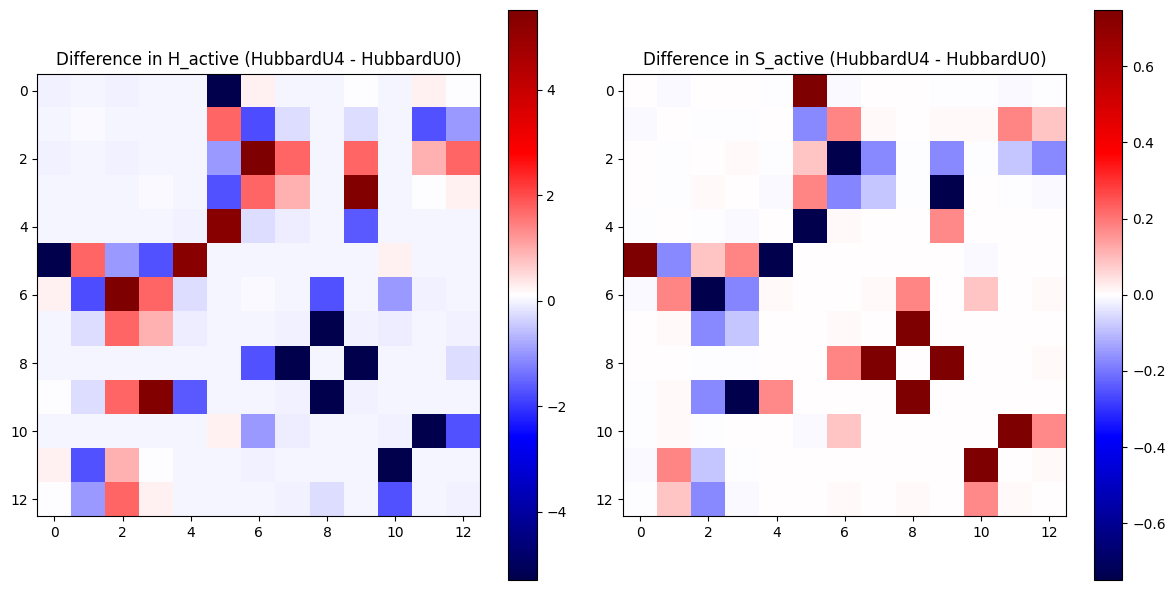

In [16]:
# Compute differences between the two files
H_active_diff = H_active_matrices[1] - H_active_matrices[0]
S_active_diff = S_active_matrices[1] - S_active_matrices[0]

# Plotting the differences as heatmaps
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot H_active difference
cax1 = axs[0].imshow(H_active_diff, cmap='seismic', interpolation='nearest')
axs[0].set_title("Difference in H_active (HubbardU4 - HubbardU0)")
fig.colorbar(cax1, ax=axs[0])

# Plot S_active difference
cax2 = axs[1].imshow(S_active_diff, cmap='seismic', interpolation='nearest')
axs[1].set_title("Difference in S_active (HubbardU4 - HubbardU0)")
fig.colorbar(cax2, ax=axs[1])

plt.tight_layout()
plt.show()